# Tensorflow Probability Implementation

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from analysis.utils import module_reload
module_reload('analysis')
from analysis.plot_matplotlib import plot_hist

# NF example

In [2]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from typing import Optional, Callable

In [3]:
def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def plot_proposal(dist, n_samples:int=1024, **kwargs):
    samples = dist.sample([n_samples]).detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    print(f'Using inferred bounds {all_min} to {all_max}')
    
    #print((all_min, all_max))
    dfbase = {}
    for i in range(len(samples.T)):
        dfbase[f'x{i}'] = samples.T[i]

    return plot_hist(pd.DataFrame(dfbase), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max), figsize=(8,6), **kwargs)

def plot_integrand(dist, func, n_samples:int=2048, vwindow=None, y_log:bool=False):
    with torch.no_grad():
        samples = dist.sample([n_samples])
        
        samples = samples.cpu()
        results = func(samples).cpu().numpy()
        
        #samples = samples.detach().cpu().numpy()
        
        
        for i in range(len(samples.T)):
            fig, ax = plt.subplots()
            #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
            ax.scatter(x=samples.T[i].numpy(),
                    y=results)
            
            if vwindow is not None:
                if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                    ax.set_ylim(vwindow[i])
                else:
                    ax.set_ylim(vwindow)
                
            ax.set_title('Integrand projection')
            ax.set_xlabel(f"Dim {i}")
            ax.set_ylabel('Integrand value')
            plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(dist, func:Callable, n_samples:int=1024, is_nf:bool=True):
    with torch.no_grad():
        samples = dist.sample([n_samples])
        prob = dist.log_prob(samples)
        prob = prob.exp() if is_nf else prob.sum(dim=1).exp()

        res = func(samples)/prob
        
        integral = (1/n_samples * res.sum()).cpu().numpy().item()
        delta = (torch.var(res).cpu()/n_samples).sqrt().numpy().item()
        
    return integral, delta

In [4]:
import tensorflow as tf
from tensorflow_probability import bijectors as tfb, distributions as dist

2024-03-20 12:07:30.415129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 12:07:31.133369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
B = 1.

int_region = np.array([
    [-10, 10],
    [-10, 10]
], dtype=float)

base = dist.Uniform(low=-B*np.ones(len(int_region)), high=B*np.ones(len(int_region)))

2024-03-20 12:07:31.972763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 12:07:31.973039: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
scale_vec = (int_region.T[1] - int_region.T[0]) / (2*B)
shift_vec = (int_region.T[1] + int_region.T[0]) / 2

transforms_forward = [
    tfb.Scale(scale_vec),
    tfb.Shift(shift_vec)
]

def transform():
    stack = tfb.Identity()
    stack = transforms_forward[0](stack)
    stack = transforms_forward[1](stack)
    
    return stack

In [7]:
transform().forward(base.sample(3))

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-5.74710538,  3.73053483],
       [ 1.36904374,  5.98557748],
       [-4.36933685, -0.67860099]])>

In [97]:
# See https://github.com/EiffL/SSELFI/blob/master/conditional_neural_spline_flow.py
class ConditionalNeuralSpline(tf.Module):
  def __init__(self, conditional_tensor=None, nbins=32, hidden_layers=[256],
               activation='relu',name=None):
    self._nbins = nbins
    self._built = False
    self._bin_widths = None
    self._bin_heights = None
    self._knot_slopes = None
    self._layers= []
    self._activation = activation
    self._hidden_layers = hidden_layers
    self._conditional_tensor = conditional_tensor
    super(ConditionalNeuralSpline, self).__init__(name)

  def __call__(self, x, nunits):
    if not self._built:
      def _bin_positions(x):
        x = tf.reshape(x, [-1, nunits, self._nbins])
        return tf.math.softmax(x, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

      def _slopes(x):
        x = tf.reshape(x, [-1, nunits, self._nbins - 1])
        return tf.math.softplus(x) + 1e-2

      for i, units in enumerate(self._hidden_layers):
        self._layers.append(tf.keras.layers.Dense(units, activation=self._activation,
                                                  name='layer_%d'%i))
      self._bin_widths = tf.keras.layers.Dense(
          nunits * self._nbins, activation=_bin_positions, name='w')

      self._bin_heights = tf.keras.layers.Dense(
          nunits * self._nbins, activation=_bin_positions, name='h')

      self._knot_slopes = tf.keras.layers.Dense(
          nunits * (self._nbins - 1), activation=_slopes, name='s')
      self._built = True

    # If provided, we append the condition as an input to the network
    if self._conditional_tensor is not None:
      net = tf.concat([x, self._conditional_tensor], axis=-1)
    else:
      net = x

    # Apply hidden layers
    for layer in self._layers:
      net = layer(net)

    return tfb.RationalQuadraticSpline(
        bin_widths=self._bin_widths(net),
        bin_heights=self._bin_heights(net),
        knot_slopes=self._knot_slopes(net))

In [88]:
class SplineCoupling(tf.Module):
    def __init__(self, name:Optional[str]=None, nbins=32, interval_width=2*B, range_min=-B,
        min_bin_width=1e-3, min_slope=1e-3):
        super().__init__(name=name)
        self._nbins = nbins
        self._interval_width = interval_width  # Sum of bin widths.
        self._range_min = range_min  # Position of first knot.
        self._min_bin_width = min_bin_width  # Bin width lower bound.
        self._min_slope = min_slope  # Lower bound for slopes at internal knots.
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def __call__(self, x, nunits):
        if not self._built:
            def _bin_positions(x):
                out_shape = tf.concat((tf.shape(x)[:-1], (nunits, self._nbins)), 0)
                x = tf.reshape(x, out_shape)
                return tf.math.softmax(x, axis=-1) * (self._interval_width - self._nbins * self._min_bin_width) + self._min_bin_width

        def _slopes(x):
            out_shape = tf.concat((tf.shape(x)[:-1], (nunits, self._nbins - 1)), 0)
            x = tf.reshape(x, out_shape)
            return tf.math.softplus(x) + self._min_slope
        
        self._bin_widths = tf.keras.layers.Dense(nunits * self._nbins, activation=_bin_positions, name='w')
        self._bin_heights = tf.keras.layers.Dense(nunits * self._nbins, activation=_bin_positions, name='h')
        self._knot_slopes = tf.keras.layers.Dense(nunits * (self._nbins - 1), activation=_slopes, name='s')
        self._built = True

        return tfb.RationalQuadraticSpline(
            bin_widths=self._bin_widths(x),
            bin_heights=self._bin_heights(x),
            knot_slopes=self._knot_slopes(x),
            range_min=self._range_min)

In [89]:
a = SplineCoupling(name="Test")
a.trainable_variables

()

In [92]:
xs = np.random.uniform(low=-B, high=B, size=(100,3)).astype(np.float32)  # Keras won't Dense(.)(vec).
a(xs, 3)

<tfp.bijectors.RationalQuadraticSpline 'RationalQuadraticSpline' batch_shape=[100, 3] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>

In [93]:
nsplits = 3

xs = np.random.uniform(low=-B, high=B, size=(100,15)).astype(np.float32)  # Keras won't Dense(.)(vec).

splines = [SplineCoupling() for _ in range(nsplits)]

def spline_flow():
    stack = tfb.Identity()
    for i in range(nsplits):
        stack = tfb.RealNVP(5 * i, bijector_fn=splines[i])(stack)
        return stack

model = spline_flow()

ys = model.forward(xs)
ys_inv = model.inverse(ys)  # ys_inv ~= xs

In [95]:
model.build

AttributeError: '_Chain' object has no attribute 'build'

In [21]:
nlayers = 4
hidden_shape = [200, 200]  # hidden shape for MADE network of MAF

bijectors = []
for i in range(0, nlayers):
    bijectors.append(tfb.RationalQuadraticSpline())
    bijectors.append(tfb.Permute(permutation=[1, 0]))  # data permutation after layers of MAF
    
bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')

maf = dist.TransformedDistribution(
    distribution=dist.Sample(base, sample_shape=[2]),
    bijector=bijector,
)


TypeError: RationalQuadraticSpline.__init__() missing 3 required positional arguments: 'bin_widths', 'bin_heights', and 'knot_slopes'

In [17]:
model.compile

AttributeError: '_Chain' object has no attribute 'compile'

In [16]:
nsplits = 3

bijectors = []
for i in range(nsplits):
    bijectors.append(SplineCoupling())
    bijectors.append(tfb.Permute([0,1,2]))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='nsf_c')
nfm = dist.TransformedDistribution(
    distribution=base,
    bijector=bijector)

AttributeError: 'SplineCoupling' object has no attribute '_is_injective'

In [88]:
model.summary()

AttributeError: '_Chain' object has no attribute 'summary'

In [86]:
a._bin_widths.count_params()

480

(array([49., 48., 28., 56., 61., 53., 42., 43., 46., 56., 55., 52., 57.,
        59., 42., 55., 47., 45., 39., 40., 48., 44., 47., 41., 50., 45.,
        44., 29., 44., 39., 52., 44.]),
 array([-9.97689128e-01, -9.35276270e-01, -8.72863472e-01, -8.10450613e-01,
        -7.48037755e-01, -6.85624897e-01, -6.23212099e-01, -5.60799241e-01,
        -4.98386383e-01, -4.35973555e-01, -3.73560727e-01, -3.11147869e-01,
        -2.48735040e-01, -1.86322197e-01, -1.23909354e-01, -6.14965111e-02,
         9.16332006e-04,  6.33291751e-02,  1.25742018e-01,  1.88154861e-01,
         2.50567704e-01,  3.12980533e-01,  3.75393391e-01,  4.37806219e-01,
         5.00219047e-01,  5.62631905e-01,  6.25044763e-01,  6.87457561e-01,
         7.49870420e-01,  8.12283278e-01,  8.74696136e-01,  9.37108934e-01,
         9.99521792e-01]),
 <BarContainer object of 32 artists>)

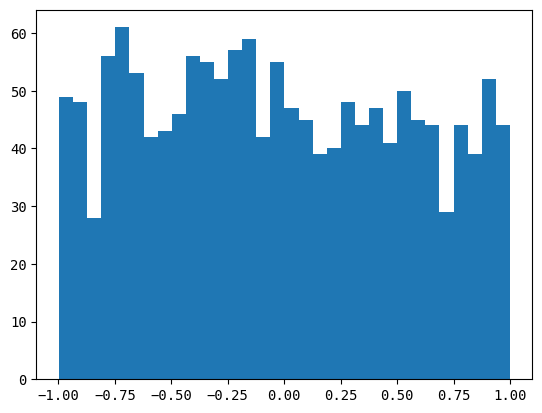

In [71]:
plt.hist(xs.flatten(), bins=32)

In [36]:
ys.numpy().max()

0.999657

Using inferred bounds -9.997232437133789 to 9.992368698120117
Using inferred bounds -9.98673152923584 to 9.997431755065918


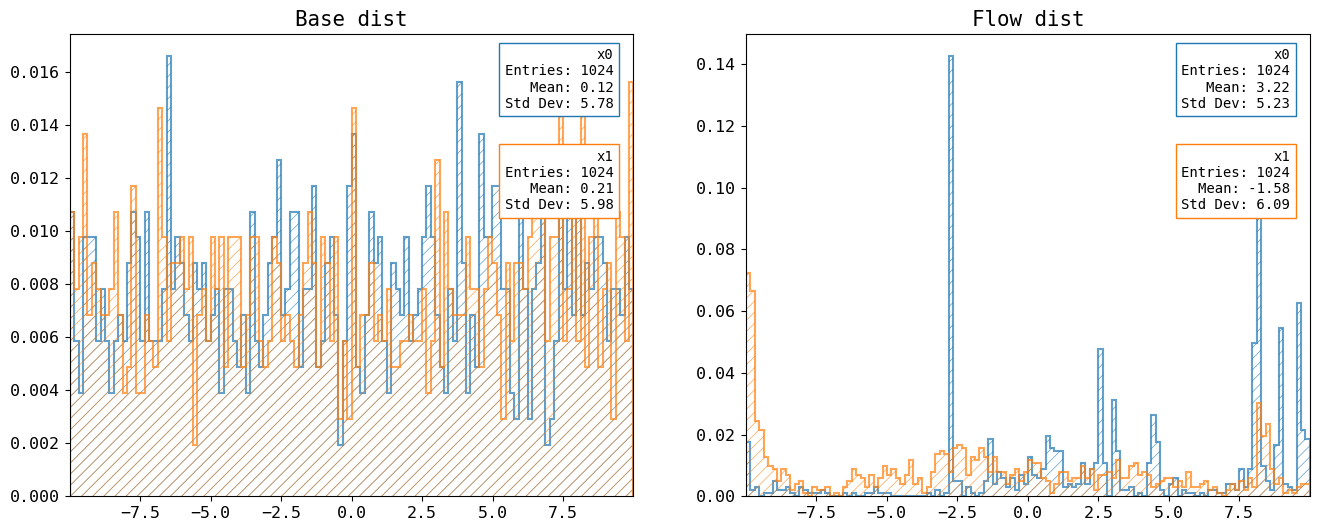

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

plot_proposal(base_dist, ax=axes[0], title='Base dist')
plot_proposal(flow_dist, ax=axes[1], title='Flow dist');

In [43]:
def func(args):
    return torch.exp(-3*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)
    
    # old center: new_width/2
    # new center: (max+min)/2
    
print(f'Uninitalized NF: {get_result(flow_dist, func, n_samples=1000000)}')
print(f'Uniform dist   : {get_result(base_dist, func, n_samples=10000, is_nf=False)}')

Uninitalized NF: (0.6851179599761963, 0.010791252367198467)
Uniform dist   : (0.6775982975959778, 0.08012820780277252)


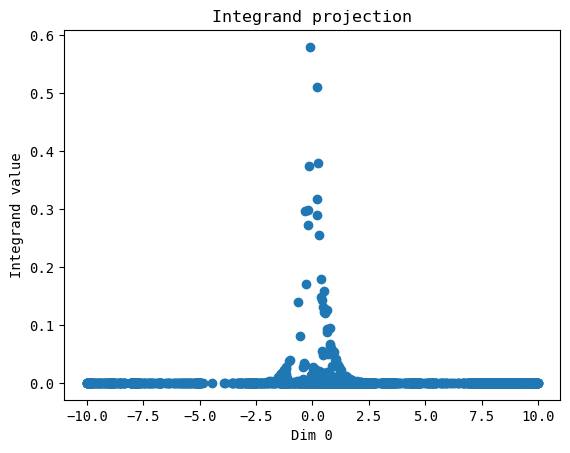

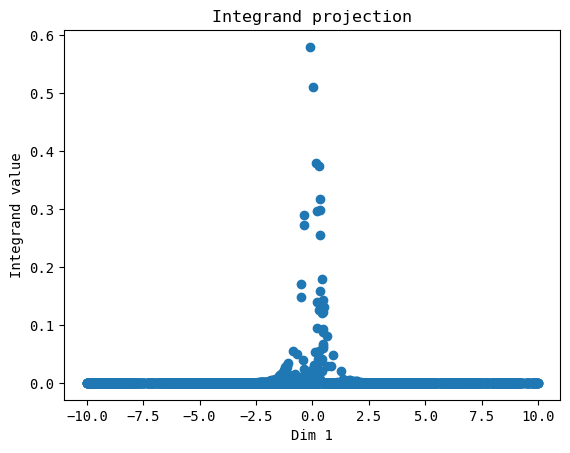

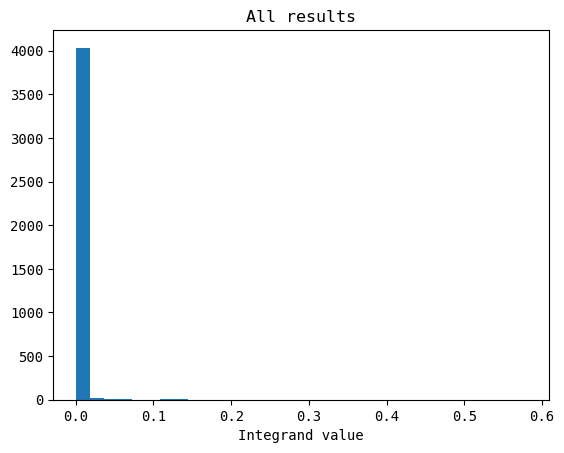

In [44]:
plot_integrand(flow_dist, func, n_samples=4096)

In [45]:
def train_iflow(flow_dist, transform, base_dist, func, n_samples:int=16384, n_epochs:int=10, lr:float=5e-3):
    optimizer = torch.optim.Adam(transform.parameters(), lr=lr)
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        z, logq = nfm.q0(n_samples)
        true = torch.abs(func(z)).detach()
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16).detach()
        
        # Transform through NFlow
        for flow in nfm.flows:
            z, log_det = flow(z)
            logq -= log_det
        
        test = logq.exp().detach()
        
        mean = torch.mean(true/test)
        var = torch.var(true/test)
        
        true = true/mean
        loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}")
        
def train_backward(flow_dist, transform, base_dist, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(transform.parameters(), lr=1e-3)
    p = base_dist.log_prob(torch.tensor([0]*2)).sum().exp().detach()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        samples = flow_dist.sample([n_samples])
        log_p = flow_dist.log_prob(samples)#.sum(dim=1)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()
        loss.backward()
        optimizer.step()
        
        flow_dist.clear_cache()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [46]:
#train_iflow(flow_dist, spline_transform, base_dist, func)
train_backward(flow_dist, spline_transform, base_dist, func)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Using inferred bounds -9.979764938354492 to 9.988386154174805
Using inferred bounds -9.988568305969238 to 9.984086990356445


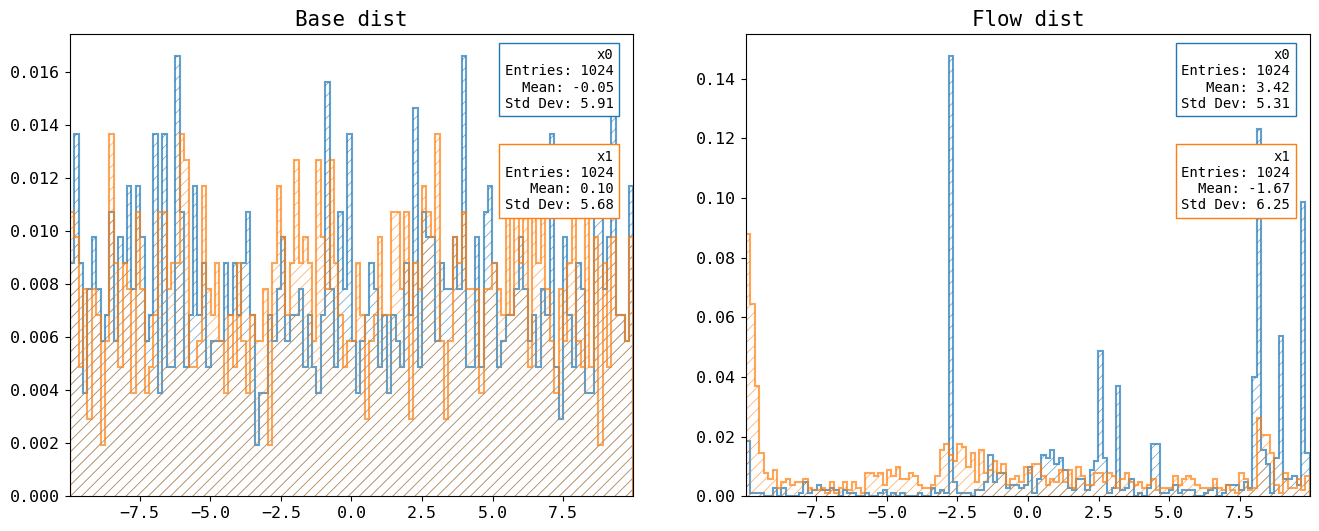

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

plot_proposal(base_dist, ax=axes[0], title='Base dist')
plot_proposal(flow_dist, ax=axes[1], title='Flow dist');

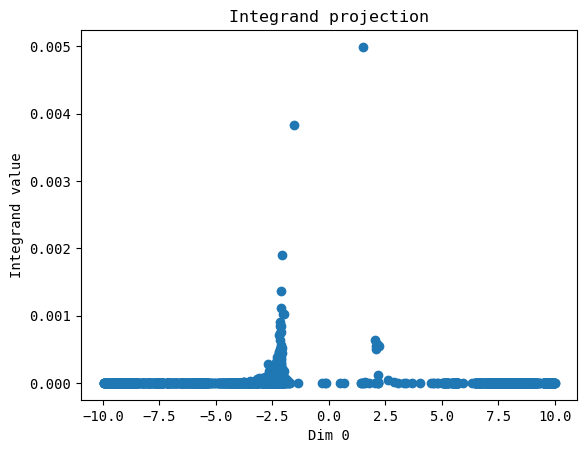

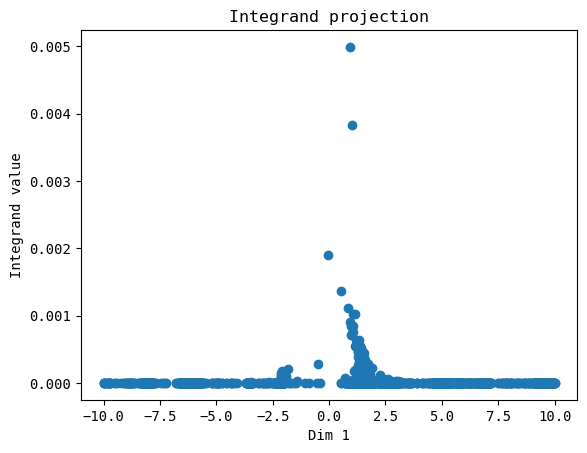

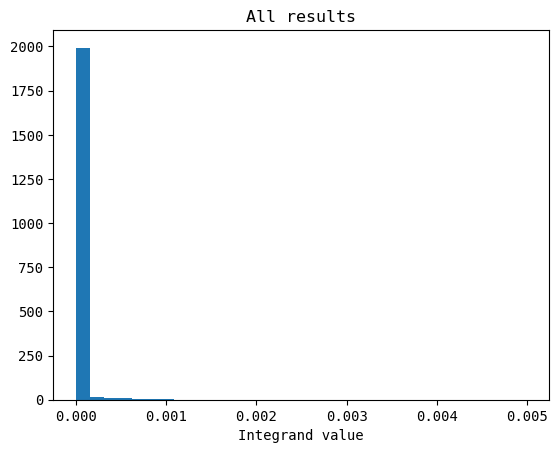

In [28]:
plot_integrand(flow_dist, func, y_log=False)

In [319]:
get_result(nfm, func, n_samples=4096)

(0.00022791343508288264, 0.00017166377801913768)

In [320]:
n_samples = 100

samples, logq = nfm.sample(n_samples)
true = torch.abs(func(samples.detach()))
test = logq.exp()
mean = torch.mean(true/test)
var = torch.var(true/test)

print(mean, torch.sqrt(var/(n_samples-1.)).item())

tensor(2.9103e-17, grad_fn=<MeanBackward0>) 2.892745231560014e-17
